<a href="https://colab.research.google.com/github/Madhuaravindh5/Learnbay_1/blob/master/Forecasting_with_Prophet_Greykite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas_profiling --upgrade

In [ ]:
import numpy as np
import datetime
import pandas as pd
import pandas_profiling
import plotly
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [ ]:
train = pd.read_csv('/content/train.csv')
feature=pd.read_csv('/content/features.csv')
test=pd.read_csv('/content/test.csv')
stores=pd.read_csv('/content/stores.csv')

In [ ]:
train_bt = pd.merge(train,stores)
train = pd.merge(train_bt,feature)
#
test_bt = pd.merge(test,stores)
test = pd.merge(test_bt,feature)

In [ ]:
print(train.shape)
print(test.shape)

(421570, 16)
(115064, 15)


In [ ]:
train = train[(train.Store==1)].groupby(["Date"]).agg({"Weekly_Sales":sum, "IsHoliday": "first",
                                                       "Type": "first", "Size": "first", "Temperature": "first",
                                                      "Fuel_Price":"first", "MarkDown1":"first", "MarkDown2":"first",
                                                      "MarkDown3":"first", "MarkDown4":"first", "MarkDown5": "first",
                                                      "CPI":"first", "Unemployment":"first"}).reset_index()
test = test[(test.Store==1)].groupby(["Date"]).agg({"IsHoliday": "first",
                                                       "Type": "first", "Size": "first", "Temperature": "first",
                                                      "Fuel_Price":"first", "MarkDown1":"first", "MarkDown2":"first",
                                                      "MarkDown3":"first", "MarkDown4":"first", "MarkDown5": "first",
                                                      "CPI":"first", "Unemployment":"first"}).reset_index()

In [ ]:
train.head(5)

Date  Weekly_Sales  IsHoliday Type    Size  Temperature  Fuel_Price  \
0  2010-02-05    1643690.90      False    A  151315        42.31       2.572   
1  2010-02-12    1641957.44       True    A  151315        38.51       2.548   
2  2010-02-19    1611968.17      False    A  151315        39.93       2.514   
3  2010-02-26    1409727.59      False    A  151315        46.63       2.561   
4  2010-03-05    1554806.68      False    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  
0         8.106  
1         8.106  
2         8.106  
3         8.106  
4         8.106

In [ ]:
test.head(5)

Date  IsHoliday Type    Size  Temperature  Fuel_Price  MarkDown1  \
0  2012-11-02      False    A  151315        55.32       3.386    6766.44   
1  2012-11-09      False    A  151315        61.24       3.314   11421.32   
2  2012-11-16      False    A  151315        52.92       3.252    9696.28   
3  2012-11-23       True    A  151315        56.23       3.211     883.59   
4  2012-11-30      False    A  151315        52.34       3.207    2460.03   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  
0    5147.70      50.82    3639.90    2737.42  223.462779         6.573  
1    3370.89      40.28    4646.79    6154.16  223.481307         6.573  
2     292.10     103.78    1133.15    6612.69  223.512911         6.573  
3       4.17   74910.32     209.91     303.32  223.561947         6.573  
4        NaN    3838.35     150.57    6966.34  223.610984         6.573

In [ ]:
train.describe()

Weekly_Sales      Size  Temperature  Fuel_Price     MarkDown1  \
count  1.430000e+02     143.0   143.000000  143.000000     51.000000   
mean   1.555264e+06  151315.0    68.306783    3.219699   8090.766275   
std    1.559808e+05       0.0    14.250486    0.427313   6606.895728   
min    1.316899e+06  151315.0    35.400000    2.514000    410.310000   
25%    1.458105e+06  151315.0    58.265000    2.764500   4089.630000   
50%    1.534850e+06  151315.0    69.640000    3.290000   6154.140000   
75%    1.614892e+06  151315.0    80.485000    3.594000   9997.650000   
max    2.387950e+06  151315.0    91.650000    3.907000  34577.060000   

          MarkDown2     MarkDown3     MarkDown4     MarkDown5         CPI  \
count     42.000000     50.000000     51.000000     51.000000  143.000000   
mean    2941.315476   1225.400400   3746.084706   5018.654902  215.996892   
std     7955.538483   7879.963965   5999.640785   3281.844937    4.350890   
min        0.500000      0.250000      8.000000    554.920000  210.337426   
25%       41.660000      6.212500    589.750000   3178.035000  211.549277   
50%      144.870000     25.965000   1822.550000   4325.190000  215.459905   
75%     1447.435000     95.725000   3695.005000   6185.645000  220.531330   
max    46011.380000  55805.510000  32403.870000  20475.320000  223.444251   

       Unemployment  
count    143.000000  
mean       7.610420  
std        0.383749  
min        6.573000  
25%        7.348000  
50%        7.787000  
75%        7.838000  
max        8.106000

In [ ]:


numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]
# Train Numerical Data
train_num=train[numeric_var_train]

# Train Categorical Data
train_cat=train[cat_var_train]
print(numeric_var_train)
print(cat_var_train)

['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [ ]:

# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()],
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=train_num.apply(lambda x: var_summary(x)).T
num_summary

N  NMISS           SUM          MEAN        MEDIAN  \
Weekly_Sales  143.0    0.0  2.224028e+08  1.555264e+06  1.534850e+06   
Size          143.0    0.0  2.163804e+07  1.513150e+05  1.513150e+05   
Temperature   143.0    0.0  9.767870e+03  6.830678e+01  6.964000e+01   
Fuel_Price    143.0    0.0  4.604170e+02  3.219699e+00  3.290000e+00   
MarkDown1      51.0   92.0  4.126291e+05  8.090766e+03  6.154140e+03   
MarkDown2      42.0  101.0  1.235352e+05  2.941315e+03  1.448700e+02   
MarkDown3      50.0   93.0  6.127002e+04  1.225400e+03  2.596500e+01   
MarkDown4      51.0   92.0  1.910503e+05  3.746085e+03  1.822550e+03   
MarkDown5      51.0   92.0  2.559514e+05  5.018655e+03  4.325190e+03   
CPI           143.0    0.0  3.088756e+04  2.159969e+02  2.154599e+02   
Unemployment  143.0    0.0  1.088290e+03  7.610420e+00  7.787000e+00   

                        STD           VAR           MIN            P1  \
Weekly_Sales  155980.767761  2.433000e+10  1.316899e+06  1.322719e+06   
Size               0.000000  0.000000e+00  1.513150e+05  1.513150e+05   
Temperature       14.250486  2.030764e+02  3.540000e+01  3.728040e+01   
Fuel_Price         0.427313  1.825960e-01  2.514000e+00  2.553460e+00   
MarkDown1       6606.895728  4.365107e+07  4.103100e+02  6.803200e+02   
MarkDown2       7955.538483  6.329059e+07  5.000000e-01  3.165000e+00   
MarkDown3       7879.963965  6.209383e+07  2.500000e-01  9.066000e-01   
MarkDown4       5999.640785  3.599569e+07  8.000000e+00  9.500000e+00   
MarkDown5       3281.844937  1.077051e+07  5.549200e+02  8.093500e+02   
CPI                4.350890  1.893024e+01  2.103374e+02  2.103608e+02   
Unemployment       0.383749  1.472632e-01  6.573000e+00  6.573000e+00   

                        P5           P10           P25           P50  \
Weekly_Sales  1.372790e+06  1.395035e+06  1.458105e+06  1.534850e+06   
Size          1.513150e+05  1.513150e+05  1.513150e+05  1.513150e+05   
Temperature   4.394100e+01  4.797200e+01  5.826500e+01  6.964000e+01   
Fuel_Price    2.603500e+00  2.633800e+00  2.764500e+00  3.290000e+00   
MarkDown1     1.625320e+03  2.585850e+03  4.089630e+03  6.154140e+03   
MarkDown2     7.507000e+00  7.824000e+00  4.166000e+01  1.448700e+02   
MarkDown3     1.816500e+00  3.042000e+00  6.212500e+00  2.596500e+01   
MarkDown4     5.257500e+01  2.257900e+02  5.897500e+02  1.822550e+03   
MarkDown5     1.263600e+03  2.312850e+03  3.178035e+03  4.325190e+03   
CPI           2.108281e+02  2.112172e+02  2.115493e+02  2.154599e+02   
Unemployment  6.908000e+00  6.908000e+00  7.348000e+00  7.787000e+00   

                       P75           P90           P95           P99  \
Weekly_Sales  1.614892e+06  1.686378e+06  1.818131e+06  2.170704e+06   
Size          1.513150e+05  1.513150e+05  1.513150e+05  1.513150e+05   
Temperature   8.048500e+01  8.548400e+01  8.698300e+01  9.041560e+01   
Fuel_Price    3.594000e+00  3.733200e+00  3.813600e+00  3.903060e+00   
MarkDown1     9.997650e+03  1.544140e+04  2.136643e+04  3.108092e+04   
MarkDown2     1.447435e+03  7.493132e+03  1.091045e+04  3.609011e+04   
MarkDown3     9.572500e+01  3.496840e+02  6.954695e+02  2.914588e+04   
MarkDown4     3.695005e+03  8.471880e+03  1.260834e+04  2.889738e+04   
MarkDown5     6.185645e+03  7.992720e+03  8.313295e+03  1.746857e+04   
CPI           2.205313e+02  2.219310e+02  2.224257e+02  2.234071e+02   
Unemployment  7.838000e+00  7.962000e+00  8.091600e+00  8.106000e+00   

                       MAX  
Weekly_Sales  2.387950e+06  
Size          1.513150e+05  
Temperature   9.165000e+01  
Fuel_Price    3.907000e+00  
MarkDown1     3.457706e+04  
MarkDown2     4.601138e+04  
MarkDown3     5.580551e+04  
MarkDown4     3.240387e+04  
MarkDown5     2.047532e+04  
CPI           2.234443e+02  
Unemployment  8.106000e+00

In [ ]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()],
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=train_cat.apply(lambda x: cat_summary(x))
cat_summary

Date  \
N                                                           143   
NMISS                                                         0   
ColumnsNames  2010-02-05    1
2011-12-23    1
2011-11-11    ...   

                                           Type  
N                                           143  
NMISS                                         0  
ColumnsNames  A    143
Name: Type, dtype: int64

In [ ]:
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]
# Train Numerical Data
test_num=test[numeric_var_test]

# Train Categorical Data
test_cat=test[cat_var_test]
print(numeric_var_test)
print(cat_var_test)

['Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [ ]:
num_summary=test_num.apply(lambda x: var_summary(x)).T
num_summary.head()

N  NMISS          SUM           MEAN      MEDIAN  \
Size         39.0    0.0  5901285.000  151315.000000  151315.000   
Temperature  39.0    0.0     2410.120      61.797949      58.590   
Fuel_Price   39.0    0.0      132.765       3.404231       3.422   
MarkDown1    39.0    0.0   355664.270    9119.596667    6343.160   
MarkDown2    31.0    8.0   120752.090    3895.228710     796.700   

                      STD           VAR         MIN           P1           P5  \
Size             0.000000  0.000000e+00  151315.000  151315.0000  151315.0000   
Temperature     12.594464  1.586205e+02      41.730      42.1822      44.6030   
Fuel_Price       0.165440  2.737034e-02       3.098       3.1018       3.1557   
MarkDown1    12166.898939  1.480334e+08     332.170     541.7096     957.6600   
MarkDown2     8102.147877  6.564480e+07       2.000       2.5850       4.0600   

                    P10          P25         P50         P75          P90  \
Size         151315.000  151315.0000  151315.000  151315.000  151315.0000   
Temperature      48.714      51.6700      58.590      72.985      80.1580   
Fuel_Price        3.192       3.2435       3.422       3.512       3.6128   
MarkDown1      2081.720    3509.7900    6343.160   11016.030   13688.0680   
MarkDown2        83.880     275.9600     796.700    3437.090    6665.5200   

                     P95           P99         MAX  
Size         151315.0000  151315.00000  151315.000  
Temperature      81.6980      83.62840      83.940  
Fuel_Price        3.6256       3.69086       3.711  
MarkDown1     21332.4910   57516.08060   72937.290  
MarkDown2     20750.4650   33580.69000   37101.130

In [ ]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()],
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=test_cat.apply(lambda x: cat_summary(x))
cat_summary

Date  \
N                                                            39   
NMISS                                                         0   
ColumnsNames  2012-11-02    1
2013-05-24    1
2013-04-05    ...   

                                          Type  
N                                           39  
NMISS                                        0  
ColumnsNames  A    39
Name: Type, dtype: int64

In [ ]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pandas_profiling.ProfileReport(test)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_corr=pd.DataFrame(train.corr())
train_corr.head()

WARNING - (py.warnings._showwarnmsg) - <ipython-input-147-ff01b84d78f1>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




Weekly_Sales  IsHoliday  Size  Temperature  Fuel_Price  \
Weekly_Sales      1.000000   0.194905   NaN    -0.222701    0.124592   
IsHoliday         0.194905   1.000000   NaN    -0.200543   -0.085903   
Size                   NaN        NaN   NaN          NaN         NaN   
Temperature      -0.222701  -0.200543   NaN     1.000000    0.228493   
Fuel_Price        0.124592  -0.085903   NaN     0.228493    1.000000   

              MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5       CPI  \
Weekly_Sales   0.090808  -0.109071   0.373671   0.088901  -0.034559  0.225408   
IsHoliday     -0.078720   0.426252   0.484969  -0.017194  -0.115828 -0.028919   
Size                NaN        NaN        NaN        NaN        NaN       NaN   
Temperature    0.128972  -0.467411  -0.087130   0.025732  -0.292917  0.118503   
Fuel_Price     0.092808  -0.301010  -0.179147   0.011074  -0.235280  0.755259   

              Unemployment  
Weekly_Sales     -0.097955  
IsHoliday         0.082949  
Size                   NaN  
Temperature      -0.180695  
Fuel_Price       -0.513944

In [ ]:
test_corr=pd.DataFrame(test.corr())
test_corr.head()

WARNING - (py.warnings._showwarnmsg) - <ipython-input-148-5bff36301416>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




IsHoliday  Size  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
IsHoliday     1.000000   NaN    -0.214432   -0.280884   0.148541   0.357966   
Size               NaN   NaN          NaN         NaN        NaN        NaN   
Temperature  -0.214432   NaN     1.000000    0.336865  -0.201800  -0.482224   
Fuel_Price   -0.280884   NaN     0.336865    1.000000   0.148132  -0.534721   
MarkDown1     0.148541   NaN    -0.201800    0.148132   1.000000   0.073433   

             MarkDown3  MarkDown4  MarkDown5       CPI  Unemployment  
IsHoliday     0.559365   0.183316  -0.210719 -0.230417      0.200933  
Size               NaN        NaN        NaN       NaN           NaN  
Temperature  -0.066495   0.007447  -0.034466  0.253266     -0.443008  
Fuel_Price   -0.198360   0.087760  -0.019585  0.711146     -0.405883  
MarkDown1    -0.115803   0.579960   0.288449  0.021922      0.082735

WARNING - (py.warnings._showwarnmsg) - <ipython-input-149-7e03ce174a05>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




<Axes: >

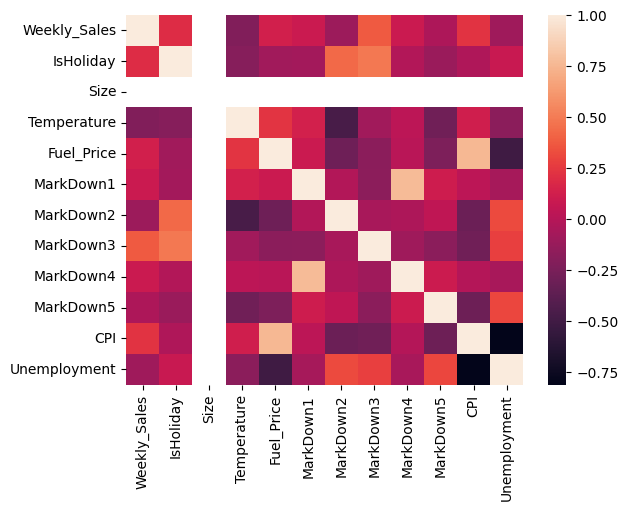

In [ ]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(train.corr())

WARNING - (py.warnings._showwarnmsg) - <ipython-input-150-62afe684b9a6>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




<Axes: >

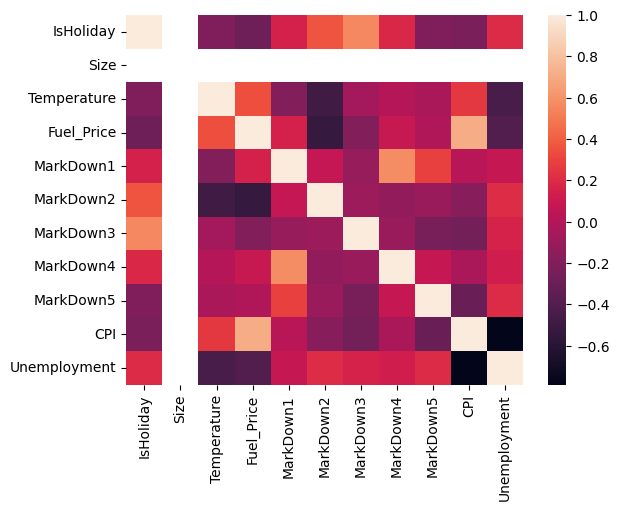

In [ ]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(test.corr())

WARNING - (py.warnings._showwarnmsg) - <ipython-input-151-3049fcd6749f>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751






`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751





<Axes: xlabel='Weekly_Sales', ylabel='Density'>

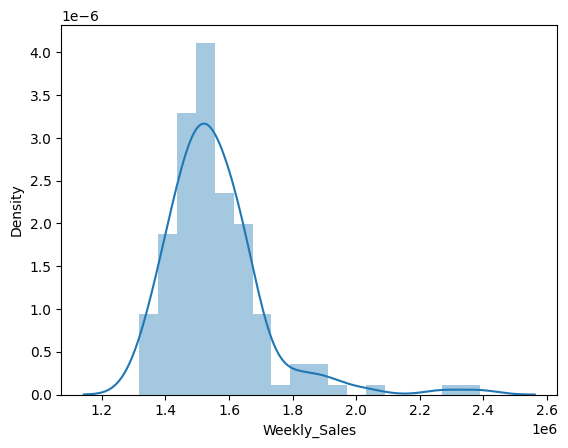

In [ ]:
sns.distplot(train.Weekly_Sales)

In [ ]:
print(train.isnull().sum())
print("*"*30)
print(test.isnull().sum())

Date              0
Weekly_Sales      0
IsHoliday         0
Type              0
Size              0
Temperature       0
Fuel_Price        0
MarkDown1        92
MarkDown2       101
MarkDown3        93
MarkDown4        92
MarkDown5        92
CPI               0
Unemployment      0
dtype: int64
******************************
Date             0
IsHoliday        0
Type             0
Size             0
Temperature      0
Fuel_Price       0
MarkDown1        0
MarkDown2        8
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI             13
Unemployment    13
dtype: int64


In [ ]:
train=train.fillna(0)
test=test.fillna(0)

In [ ]:
print(train.isnull().sum())
print("*"*30)
print(test.isnull().sum())

Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
******************************
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [ ]:
train.Weekly_Sales=np.where(train.Weekly_Sales>2000000, 2000000,train.Weekly_Sales)

<Axes: ylabel='Frequency'>

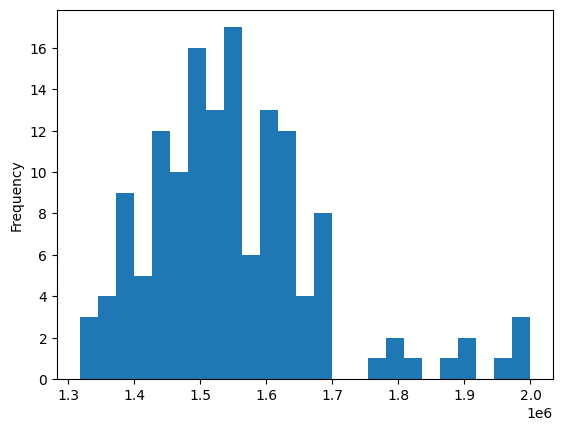

In [ ]:
train.Weekly_Sales.plot.hist(bins=25)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
 2   IsHoliday     143 non-null    bool   
 3   Type          143 non-null    object 
 4   Size          143 non-null    int64  
 5   Temperature   143 non-null    float64
 6   Fuel_Price    143 non-null    float64
 7   MarkDown1     143 non-null    float64
 8   MarkDown2     143 non-null    float64
 9   MarkDown3     143 non-null    float64
 10  MarkDown4     143 non-null    float64
 11  MarkDown5     143 non-null    float64
 12  CPI           143 non-null    float64
 13  Unemployment  143 non-null    float64
dtypes: bool(1), float64(10), int64(1), object(2)
memory usage: 14.8+ KB


In [ ]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [ ]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day

In [ ]:
print(train.Type.value_counts())
print("*"*30)
print(test.Type.value_counts())

A    143
Name: Type, dtype: int64
******************************
A    39
Name: Type, dtype: int64


In [ ]:
print(train.IsHoliday.value_counts())
print("*"*30)
print(test.IsHoliday.value_counts())

False    133
True      10
Name: IsHoliday, dtype: int64
******************************
False    36
True      3
Name: IsHoliday, dtype: int64


In [ ]:
train_test_data = [train, test]

In [ ]:

type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

In [ ]:
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [ ]:
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [ ]:
train.head(5)

Date  Weekly_Sales  IsHoliday  Type    Size  Temperature  Fuel_Price  \
0 2010-02-05    1643690.90          0     1  151315        42.31       2.572   
1 2010-02-12    1641957.44          1     1  151315        38.51       2.548   
2 2010-02-19    1611968.17          0     1  151315        39.93       2.514   
3 2010-02-26    1409727.59          0     1  151315        46.63       2.561   
4 2010-03-05    1554806.68          0     1  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  Date_dayofweek  Date_month  \
0        0.0        0.0        0.0        0.0               4           2   
1        0.0        0.0        0.0        0.0               4           2   
2        0.0        0.0        0.0        0.0               4           2   
3        0.0        0.0        0.0        0.0               4           2   
4        0.0        0.0        0.0        0.0               4           3   

   Date_year  Date_day  
0       2010         5  
1       2010        12  
2       2010        19  
3       2010        26  
4       2010         5

In [ ]:
train['Date'] = train['Date'].astype('datetime64[ns]')
train.rename(columns = {'Date': 'ds', 'Weekly_Sales': 'y'}, inplace = True)

In [ ]:

#df = train[['ts', 'y']]
df = train[['ds', 'Temperature', 'Fuel_Price', 'IsHoliday', 'y']]

In [ ]:
df.sort_values(by=["ds"], inplace=True)

In [ ]:
df = df.set_index('ds')

<Axes: xlabel='ds'>

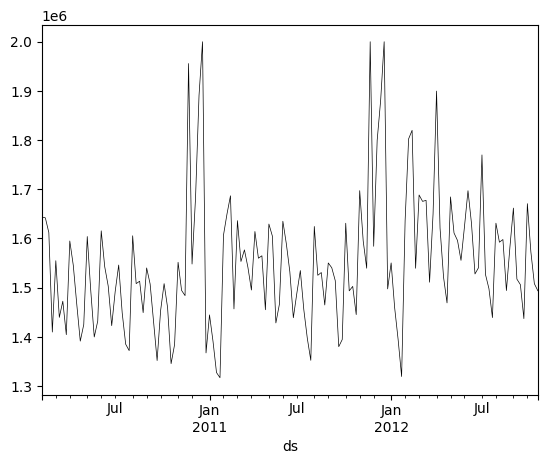

In [ ]:

df['y'].plot(linewidth=0.5, alpha=0.99, color='black')

In [ ]:
!pip install neuralprophet

In [ ]:
!pip install greykite

In [ ]:
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries

## Trend

In [ ]:
model = ChangepointDetector()
res = model.find_trend_changepoints(
 df=df.reset_index(),  # data df
 time_col="ds",  # time column name
 value_col="y",  # value column name
 yearly_seasonality_order=10,  # yearly seasonality order, fit along with trend
 regularization_strength=0.5,  # between 0.0 and 1.0, greater values imply fewer changepoints, and 1.0 implies no changepoints
 resample_freq="7D",  # data aggregation frequency, eliminate small fluctuation/seasonality
 potential_changepoint_n=25,  # the number of potential changepoints
 yearly_seasonality_change_freq="365D",  # varying yearly seasonality for every year
 no_changepoint_distance_from_end="365D")  # the proportion of data from end where changepoints are not allowed
fig = model.plot(
 observation=True,
 trend_estimate=False,
 trend_change=True,
 yearly_seasonality_estimate=False,
 adaptive_lasso_estimate=True,
 plot=False)
plotly.io.show(fig, renderer="colab")

## Seasonality

In [ ]:
ts = UnivariateTimeSeries()
ts.load_data(
            df=df.reset_index(),
            time_col="ds",
            value_col="y",
            freq="W-FRI")

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/common/time_properties.py:418: UserWarning:

`train_end_date` is not provided, or y column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2012-10-26 00:00:00).



`train_end_date` is not provided, or y column of the provided time series contains null values at the end, or the input `train_end_date` is beyond the last timestamp available. Setting `train_end_date` to the last timestamp with a non-null value (2012-10-26 00:00:00).




In [ ]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="doy",  # day of quarter
     show_mean=True,
     show_quantiles=True,
     show_overlays=20,  # randomly selects up to 20 overlays
     # No explicit overlay feature. Each overlay is a single cycle (quarter)
     center_values=True,
     xlabel="day of year",
     ylabel=ts.original_value_col,
     title="yearly seasonality",
 )
plotly.io.show(fig, renderer="colab")

In [ ]:
fig = ts.plot_quantiles_and_overlays(
     groupby_time_feature="dom",  # day of quarter
     show_mean=True,
     show_quantiles=True,
     show_overlays=20,  # randomly selects up to 20 overlays
     # No explicit overlay feature. Each overlay is a single cycle (quarter)
     center_values=True,
     xlabel="day of month",
     ylabel=ts.original_value_col,
     title="monthly seasonality",
 )
plotly.io.show(fig, renderer="colab")

## Silverkite

In [ ]:
# Specifies dataset information
metadata = MetadataParam(
     time_col="ds",  # name of the time column
     value_col="y",  # name of the value column
     freq="W-FRI",  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
     train_end_date=datetime.datetime(2012, 6, 8)
)

forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df = df.reset_index(),
     config = ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=20,  # forecasts 20 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata,
         model_components_param=ModelComponentsParam(
             autoregression=None,
             regressors={
             "regressor_cols": ["Temperature", "Fuel_Price", "IsHoliday"]
             },
             events={
                 "holidays_to_model_separately": "auto",
                 "holiday_lookup_countries": ["UnitedStates"]
             },
              growth = {
                 "growth_term": "linear"
             },
             changepoints = {
                 "changepoints_dict": dict(
                     method="auto",
                     yearly_seasonality_order=10,
                     regularization_strength=0.5,
                     potential_changepoint_n=5,
                     yearly_seasonality_change_freq="365D",
                     no_changepoint_distance_from_end="365D"
                 )
             }
         )
    )
)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Chinese New Year' does not occur in the provided countries



Requested holiday 'Chinese New Year' does not occur in the provided countries


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Good Friday' does not occur in the provided countries



Requested holiday 'Good Friday' does not occur in the provided countries


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/forecast/silverkite/forecast_simple_silverkite_helper.py:130: UserWarning:

Requested holiday 'Easter Monday [England, Wales, Northern Ireland]' does not occur in the provided countries



Requested holiday 'Easter Monday [England, Wales, Northern Ireland]'

Fitting 3 folds for each of 1 candidates, totalling 3 fits


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/changepoint/adalasso/changepoints_utils.py:1359: UserWarning:

No yearly seasonality changepoint added. Either data length is too short or yearly_seasonality_change_freq is too long.



No yearly seasonality changepoint added. Either data length is too short or yearly_seasonality_change_freq is too long.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/forecast/silverkite/forecast_silverkite.py:2906: UserWarning:

The granularity of data is larger than daily. Ensure the daily events data match the timestamps



The granularity of data is larger than daily. Ensure the daily events data match the timestamps


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:279: UserWarning:

Re-constructing `h_mat @ h_mat.T` by `lu_d_sqrt @ lu_d_sqrt.T` has a bigger relative error 1.

In [ ]:
result.forecast.compute_evaluation_metrics_split()

{'Train': {'CORR': 0.9704011397834049,
  'R2': 0.9411800698633419,
  'MSE': 1184853477.4275386,
  'RMSE': 34421.700675991284,
  'MAE': 26630.88386398722,
  'MedAE': 19967.70503386692,
  'MAPE': 1.7159156264236266,
  'MedAPE': 1.3002288745327837,
  'sMAPE': 0.8582240910483756,
  'Q80': 13315.441931993522,
  'Q95': 13315.441931993482,
  'Q99': 13315.441931993468,
  'OutsideTolerance1p': 0.6341463414634146,
  'OutsideTolerance2p': 0.35772357723577236,
  'OutsideTolerance3p': 0.15447154471544716,
  'OutsideTolerance4p': 0.07317073170731707,
  'OutsideTolerance5p': 0.024390243902439025,
  'Outside Tolerance (fraction)': None,
  'R2_null_model_score': None,
  'Prediction Band Width (%)': 13.142664934601534,
  'Prediction Band Coverage (fraction)': 0.991869918699187,
  'Coverage: Lower Band': 0.5040650406504065,
  'Coverage: Upper Band': 0.4878048780487805,
  'Coverage Diff: Actual_Coverage - Intended_Coverage': 0.04186991869918699,
  'MIS': 212818.02470707454},
 'Test': {'CORR': 0.9100859293

In [ ]:
result.forecast.plot()

FigureWidgetResampler({
    'data': [{'legendgroup': 'interval',
              'line': {'color': 'rgba(0, 90, 181, 0.5)', 'width': 0.0},
              'mode': 'lines',
              'name': 'Lower Bound',
              'type': 'scatter',
              'uid': '78331a51-e00f-4f1f-891e-9114240e655a',
              'x': array([datetime.datetime(2010, 2, 5, 0, 0),
                          datetime.datetime(2010, 2, 12, 0, 0),
                          datetime.datetime(2010, 2, 19, 0, 0),
                          datetime.datetime(2010, 2, 26, 0, 0),
                          datetime.datetime(2010, 3, 5, 0, 0),
                          datetime.datetime(2010, 3, 12, 0, 0),
                          datetime.datetime(2010, 3, 19, 0, 0),
                          datetime.datetime(2010, 3, 26, 0, 0),
                          datetime.datetime(2010, 4, 2, 0, 0),
                          datetime.datetime(2010, 4, 9, 0, 0),
                          datetime.datetime(2010, 4, 16, 0, 0),
 

In [ ]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(grid_search=grid_search, decimals=2,
    # The below saves space in the printed output. Remove to show all available metrics and columns.
    cv_report_metrics=None,
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params                            []
rank_test_MAPE                     1
mean_test_MAPE                  5.48
split_test_MAPE   (8.98, 2.95, 4.51)
mean_train_MAPE                 1.79
split_train_MAPE  (1.05, 2.01, 2.31)
mean_fit_time                   5.95
mean_score_time                 1.82

## Neural Prophet

In [ ]:
df = df.reset_index()

In [ ]:
print(df.ds.min())
print(df.ds.max())

2010-02-05 00:00:00
2012-10-26 00:00:00


In [ ]:
test_length = 20
df_train = df.iloc[:-test_length]
df_test = df.iloc[-test_length:]

In [ ]:
model = NeuralProphet(loss_func='MSE', n_changepoints=2, seasonality_mode='additive')
model.add_future_regressor('Temperature')
model.add_future_regressor('Fuel_Price')
model.add_future_regressor('IsHoliday')

In [ ]:
df

index         ds  Temperature  Fuel_Price  IsHoliday           y
0        0 2010-02-05        42.31       2.572          0  1643690.90
1        1 2010-02-12        38.51       2.548          1  1641957.44
2        2 2010-02-19        39.93       2.514          0  1611968.17
3        3 2010-02-26        46.63       2.561          0  1409727.59
4        4 2010-03-05        46.50       2.625          0  1554806.68
..     ...        ...          ...         ...        ...         ...
138    138 2012-09-28        76.08       3.666          0  1437059.26
139    139 2012-10-05        68.55       3.617          0  1670785.97
140    140 2012-10-12        62.99       3.601          0  1573072.81
141    141 2012-10-19        67.97       3.594          0  1508068.77
142    142 2012-10-26        69.16       3.506          0  1493659.74

[143 rows x 6 columns]

In [ ]:
 model.fit(df_train, freq="W")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 99.187% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W


ValueError: ignored

In [ ]:
future_df = model.make_future_dataframe(df_test, periods = test_length, n_historic_predictions=len(df_test),
                                        regressors_df=df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-FRI corresponds to 95.0% of the data.
INFO:NP.df_utils:Major frequency W-FRI corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [ ]:
future_df.head()

index         ds  Temperature  Fuel_Price  IsHoliday           y
0    123 2012-06-15        79.35       3.393          0  1630607.00
1    124 2012-06-22        78.39       3.346          0  1527845.81
2    125 2012-06-29        84.88       3.286          0  1540421.49
3    126 2012-07-06        81.57       3.227          0  1769854.16
4    127 2012-07-13        77.12       3.256          0  1527014.04

In [ ]:
 model.fit(future_df)

ValueError: ignored

In [ ]:
forecast = model.predict(future_df)

ValueError: ignored

In [ ]:
forecast.head()

NameError: ignored

In [ ]:
model.plot(forecast)

NameError: ignored

In [ ]:
df_test['neural_prophet'] = forecast.iloc[-test_length:].loc[:, 'yhat1']

NameError: ignored

In [ ]:
print(f"NeuralProphet:\t{mean_absolute_percentage_error(df_test['y'], forecast.iloc[-test_length:]['yhat1']):.4f}")

NeuralProphet:	0.0495


In [ ]:
silverkite_df = result.forecast.df_test
#prophet_df = forecast.head(test_length)

#print(silverkite_df.shape, prophet_df.shape)

In [ ]:
silverkite_df.set_index('ds', inplace=True)
silverkite_df.head()

KeyError: ignored

In [ ]:
prophet_df.set_index('ds', inplace=True)
prophet_df.head()

NameError: ignored

In [ ]:
print(f"Silverkite(MAPE):\t{mean_absolute_percentage_error(silverkite_df['actual'], silverkite_df['forecast']):.4f}")
#print(f"NeuralProphet(MAPE:\t{mean_absolute_percentage_error(prophet_df['y'], prophet_df['yhat1']):.4f}")

print(f"Silverkite(RMSE):\t{math.sqrt(mean_squared_error(silverkite_df['actual'], silverkite_df['forecast'])):.4f}")
#print(f"NeuralProphet(RMSE):\t{math.sqrt(mean_squared_error(prophet_df['y'], prophet_df['yhat1'])):.4f}")

Silverkite(MAPE):	0.0178
Silverkite(RMSE):	38165.7319


<Axes: >

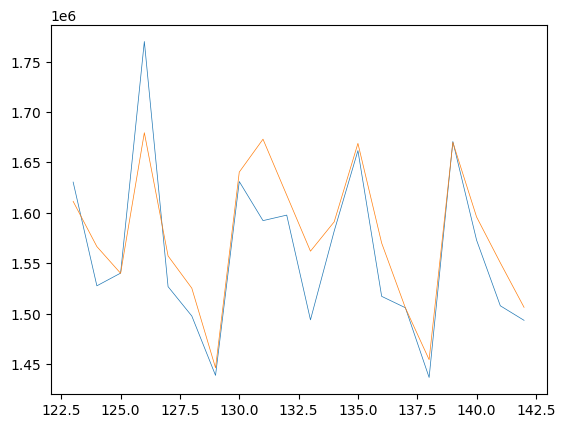

In [ ]:
silverkite_df['actual'].plot(linewidth=0.5)
silverkite_df['forecast'].plot(linewidth=0.5)

In [ ]:
prophet_df['y'].plot(linewidth=0.5)
prophet_df['yhat1'].plot(linewidth=0.5)

NameError: ignored

In [ ]:
silverkite_df

ts      actual      forecast  forecast_lower  forecast_upper
123 2012-06-15  1630607.00  1.611483e+06    1.507589e+06    1.715378e+06
124 2012-06-22  1527845.81  1.566716e+06    1.461428e+06    1.672004e+06
125 2012-06-29  1540421.49  1.540259e+06    1.432207e+06    1.648312e+06
126 2012-07-06  1769854.16  1.679495e+06    1.572633e+06    1.786356e+06
127 2012-07-13  1527014.04  1.557443e+06    1.451905e+06    1.662981e+06
128 2012-07-20  1497954.76  1.525512e+06    1.420469e+06    1.630556e+06
129 2012-07-27  1439123.71  1.446575e+06    1.342557e+06    1.550594e+06
130 2012-08-03  1631135.79  1.640480e+06    1.536046e+06    1.744915e+06
131 2012-08-10  1592409.97  1.673071e+06    1.568296e+06    1.777847e+06
132 2012-08-17  1597868.05  1.617632e+06    1.514051e+06    1.721214e+06
133 2012-08-24  1494122.38  1.562154e+06    1.457426e+06    1.666883e+06
134 2012-08-31  1582083.40  1.591226e+06    1.487218e+06    1.695234e+06
135 2012-09-07  1661767.33  1.668917e+06    1.562839e+06    1.774996e+06
136 2012-09-14  1517428.87  1.570207e+06    1.462614e+06    1.677800e+06
137 2012-09-21  1506126.06  1.505944e+06    1.400754e+06    1.611134e+06
138 2012-09-28  1437059.26  1.454727e+06    1.351580e+06    1.557875e+06
139 2012-10-05  1670785.97  1.669961e+06    1.566551e+06    1.773371e+06
140 2012-10-12  1573072.81  1.596042e+06    1.492095e+06    1.699990e+06
141 2012-10-19  1508068.77  1.550627e+06    1.446943e+06    1.654312e+06
142 2012-10-26  1493659.74  1.506527e+06    1.399482e+06    1.613573e+06

In [ ]:
a=silverkite_df.actual
b=silverkite_df.forecast

ValueError: ignored